In [1]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset
df = pd.read_csv("intermedio_sin_outliers.csv")
dfbasico = pd.read_csv("dataset_crudo.csv")

print("Dataset cargado con éxito.")

Dataset cargado con éxito.


In [2]:
#extraer columna modelo de dfbasico
dfbasico_modelo = dfbasico['Modelo']
#contar ocurrencias de cada modelo
modelo_counts = dfbasico_modelo.value_counts()
modelo_map = {
    'SW4': 'Hilux SW4',
    'q5 sportback': 'Q5',
    'Q3 Sportback': 'Q3',
    'Tiguan Allspace': 'Tiguan',
    'DS7': 'DS7 Crossback',
    'Tiggo 2': 'Tiggo',
    'Tiggo 3': 'Tiggo',
    'Tiggo 4': 'Tiggo',
    'Tiggo 5': 'Tiggo',
    'ML': 'Clase GLE',
    'Clase ML': 'Clase GLE',
    'X-Terra': 'X-Trail',
    'Samurai': 'Jimny',
    'Grand Blazer': 'Trailblazer'
}

# Aplicar reemplazo
dfbasico['Modelo'] = dfbasico['Modelo'].replace(modelo_map)
# Mostrar hasta 200 filas completas (ajustá según necesites)
pd.set_option('display.max_rows', 200)

# Ahora imprimí normalmente
print("Conteo de modelos:")
print(modelo_counts)


Conteo de modelos:
Modelo
Ecosport             1569
Tracker              1511
2008                 1144
Duster               1048
Compass               916
Kicks                 913
Taos                  687
Renegade              643
T-Cross               540
Corolla Cross         482
C4 Cactus             453
Nivus                 436
Tucson                417
Pulse                 341
HR-V                  339
Hilux SW4             322
Territory             280
X1                    264
CR-V                  246
Captur                229
C3 Aircross           228
SW4                   224
Tiguan                211
Q5                    196
Grand Cherokee        193
Journey               185
Kuga                  177
RAV4                  173
X6                    150
Tiguan Allspace       147
Tiggo                 145
Trailblazer           139
Commander             117
Bronco Sport          117
Q3                    114
Sportage              110
Wrangler              109
Duster Oroch

In [3]:
df = df.loc[:, ~df.columns.str.startswith('Modelo')]

df['Modelo'] = dfbasico['Modelo']
#muestras de modelo en el dataset df
muestras_modelo = df['Modelo'].value_counts()

# hacer encoding a columna modelo 
# Guardás los valores únicos durante el factorize
df['Modelo'], modelo_labels = pd.factorize(df['Modelo'])

# Consultar el mapeo
print("Modelo codificado  →  Nombre original")
for i, name in enumerate(modelo_labels):
    print(f"{i} → {name}")

Modelo codificado  →  Nombre original
0 → Ecosport
1 → Tiguan
2 → Compass
3 → X55
4 → Sorento
5 → Tucson
6 → Cayenne
7 → Renegade
8 → 2008
9 → Pulse
10 → Tracker
11 → C4 Cactus
12 → Wrangler
13 → X1
14 → 3008
15 → Q5
16 → Taos
17 → CR-V
18 → Kicks
19 → Q3
20 → Clase GLE
21 → HR-V
22 → Duster
23 → Vitara
24 → T-Cross
25 → RAV4
26 → Kuga
27 → Creta
28 → Corolla Cross
29 → Hilux SW4
30 → Blazer
31 → DS7 Crossback
32 → Trailblazer
33 → Grand Cherokee
34 → Nivus
35 → Santa Fe
36 → X3
37 → Tiggo
38 → X-Trail
39 → X6
40 → Q7
41 → Terios
42 → C3 Aircross
43 → Panamera
44 → X35
45 → Musso
46 → Journey
47 → Duster Oroch
48 → X4
49 → Bronco Sport
50 → Commander
51 → S2
52 → Touareg
53 → Captur
54 → Equinox
55 → 500X
56 → Territory
57 → X5
58 → Q8
59 → Land Cruiser
60 → Macan
61 → Soul
62 → C3
63 → Q2
64 → Range Rover
65 → Galloper
66 → Koleos
67 → Stelvio
68 → Clase GLA
69 → Grand Vitara
70 → Cherokee
71 → Discovery
72 → Jolion
73 → XC60
74 → Evoque
75 → Terrano II
76 → Myway
77 → Clase GLC
78 → 

In [4]:
# ==============================
# 1. ANTIGÜEDAD
# ==============================

anio_actual = 2025
df['antiguedad'] = anio_actual - df['Año']

# Verificar los valores mínimos

df.drop(columns=['Año'], inplace=True)

df = df[df['antiguedad'] != -434669.0]


# ==============================

# 4.2 Normalización de antigüedad y log de km
df['antiguedad_norm'] = df['antiguedad'] / df['antiguedad'].max()
df['km_log'] = np.log1p(df['Kilómetros'])

# 4.3 Score de estado del auto antiguedad vs log 
df['score_estado_auto'] = (
    0.5 * (1 - df['antiguedad_norm']) + 
    0.5 * (1 - df['km_log'] / df['km_log'].max())
)

# Clasificación por antigüedad
def clasificar_antiguedad(años):
    if años > 10:
        return 'viejo'
    elif años > 5:
        return 'usable'
    else:
        return 'relativamente_nuevo'

df['estado_edad'] = df['antiguedad'].apply(clasificar_antiguedad)






# ==============================
# 2. GMM: Búsqueda de n_components con BIC
# ==============================

X_cluster = df[['antiguedad', 'Kilómetros']]
scaler_gmm = StandardScaler()
X_scaled_gmm = scaler_gmm.fit_transform(X_cluster)

bics = []
components_range = range(2, 11)

for n in components_range:
    gmm = GaussianMixture(n_components=n, random_state=42, reg_covar=1e-3)
    gmm.fit(X_scaled_gmm)
    bics.append(gmm.bic(X_scaled_gmm))

best_n_components = components_range[np.argmin(bics)]
print(f"✅ Mejor n_components según BIC: {best_n_components}")

# Ajustar GMM final
gmm = GaussianMixture(n_components=best_n_components, random_state=42, reg_covar=1e-3)
gmm.fit(X_scaled_gmm)

# Etiquetas originales
labels = gmm.predict(X_scaled_gmm)
df['cluster_gmm'] = labels

# ==============================
# Fusionar clusters con menos de 500 elementos
# ==============================

# Contar elementos por cluster
counts = pd.Series(labels).value_counts()
clusters_chicos = counts[counts < 500].index.tolist()

# Medias de cada componente
medias = gmm.means_

# Matriz de distancias entre medias
distancias = cdist(medias, medias)
np.fill_diagonal(distancias, np.inf)  # Evitar que se elijan a sí mismos

# Reasignar clusters chicos al más cercano con ≥ 500 elementos
labels_corr = labels.copy()
for chico in clusters_chicos:
    candidatos = [i for i in range(len(medias)) if i not in clusters_chicos]
    
    if not candidatos:
        vecino = np.argmin(distancias[chico])  # fallback
    else:
        distancias_validas = distancias[chico][candidatos]
        vecino = candidatos[np.argmin(distancias_validas)]

    print(f"➡️ Cluster chico {chico} (n={counts[chico]}) reasignado a cluster {vecino}")
    labels_corr[labels == chico] = vecino

# Guardar etiquetas corregidas
df['cluster_gmm_fusionado'] = labels_corr

# Reindexar los clusters fusionados para que sean consecutivos
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['cluster_gmm_fusionado_reindexado'] = encoder.fit_transform(df['cluster_gmm_fusionado'])


# ==============================
# Mostrar resultados
# ==============================
print(f"✅ GMM: mejor n_components = {best_n_components}")



✅ Mejor n_components según BIC: 10
➡️ Cluster chico 9 (n=484) reasignado a cluster 2
➡️ Cluster chico 5 (n=430) reasignado a cluster 2
✅ GMM: mejor n_components = 10


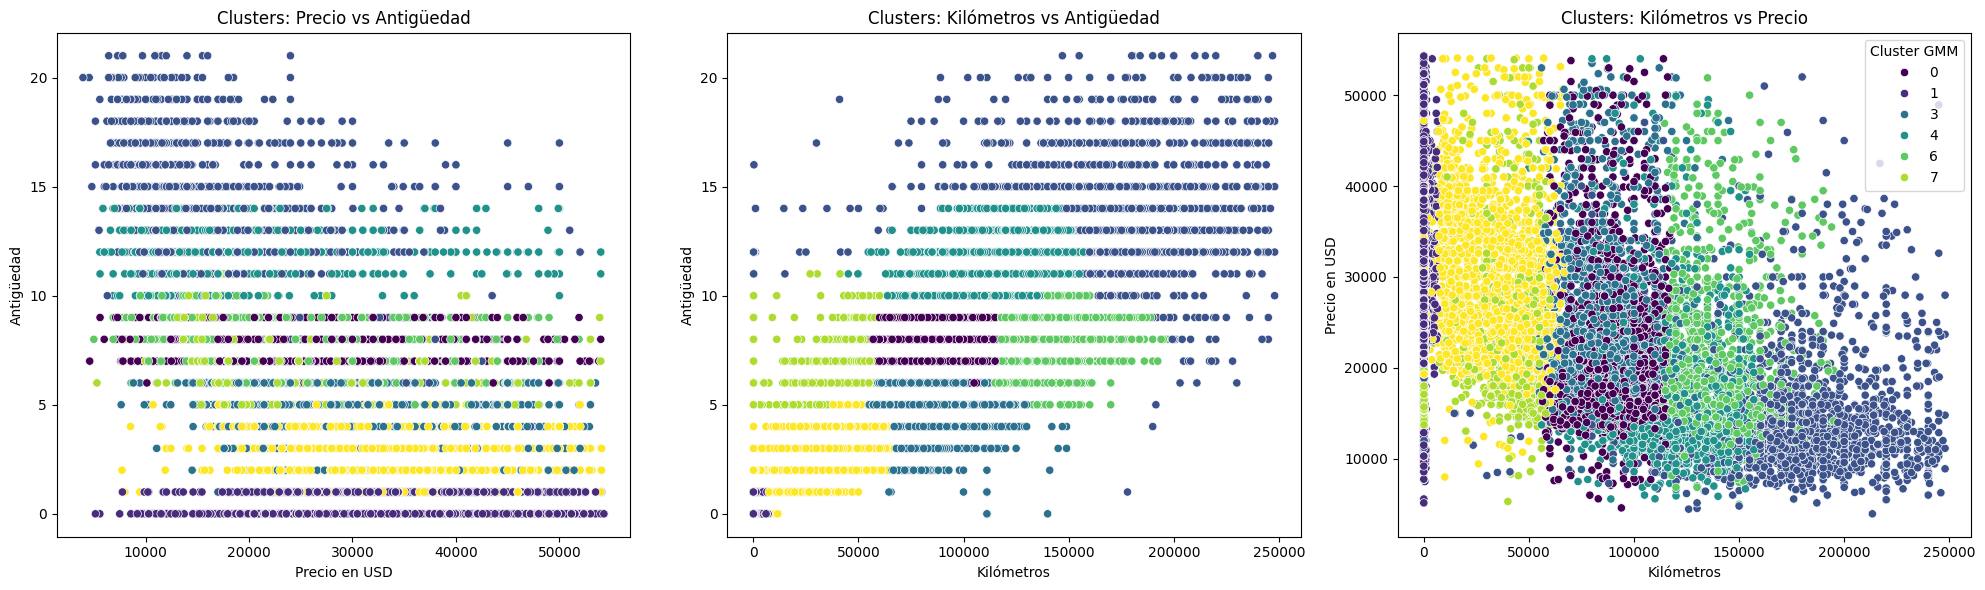

GMM:
cluster_gmm_fusionado
0    2461
1    4632
2    1937
3    1923
4    1624
6    1240
7     714
8    2350
Name: count, dtype: int64
Silhouette score: 0.437


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar datos para graficar (sacar outliers extremos)
q_km = df['Kilómetros'].quantile(0.99)
q_price = df['Precio_usd'].quantile(0.99)
df_plot = df[(df['Kilómetros'] <= q_km) & (df['Precio_usd'] <= q_price)]

# Crear subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# ----------- Gráfico 1: Precio vs Antigüedad -----------
sns.scatterplot(
    x='Precio_usd', y='antiguedad',
    hue='cluster_gmm_fusionado', data=df_plot, palette='viridis',
    ax=axs[0], legend=False
)
axs[0].set_title('Clusters: Precio vs Antigüedad')
axs[0].set_xlabel('Precio en USD')
axs[0].set_ylabel('Antigüedad')

# ----------- Gráfico 2: Kilómetros vs Antigüedad -----------
sns.scatterplot(
    x='Kilómetros', y='antiguedad',
    hue='cluster_gmm_fusionado', data=df_plot, palette='viridis',
    ax=axs[1], legend=False
)
axs[1].set_title('Clusters: Kilómetros vs Antigüedad')
axs[1].set_xlabel('Kilómetros')
axs[1].set_ylabel('Antigüedad')

# ----------- Gráfico 3: Precio vs Kilómetros -----------
sns.scatterplot(
    x='Kilómetros', y='Precio_usd',
    hue='cluster_gmm_fusionado', data=df_plot, palette='viridis',
    ax=axs[2]
)
axs[2].set_title('Clusters: Kilómetros vs Precio')
axs[2].set_xlabel('Kilómetros')
axs[2].set_ylabel('Precio en USD')
axs[2].legend(title='Cluster GMM', loc='upper right')

# Ajustar layout
plt.tight_layout()
plt.show()

# Mostrar distribución de clusters
print("GMM:")
print(df['cluster_gmm_fusionado'].value_counts().sort_index())

from sklearn.metrics import silhouette_score
score = silhouette_score(X_scaled_gmm, labels_corr)
print(f"Silhouette score: {score:.3f}")



In [6]:
# One-hot encoding y conversión a enteros
estado_dummies = pd.get_dummies(df['estado_edad'], prefix='estado').astype(int)

# Reemplazar en el DataFrame
df = pd.concat([df.drop(columns=['estado_edad']), estado_dummies], axis=1)
# imprimir las primeras filas del dataset final
pd.set_option('display.max_rows', 200)
#drop columna Precio_usd_z


df.drop(columns=['antiguedad_norm', 'km_log'], inplace=True)

df.drop(columns=['cluster_gmm_fusionado','cluster_gmm'], inplace=True, errors='ignore')


#one hot con cluster 
df = pd.get_dummies(df, columns=['cluster_gmm_fusionado_reindexado'], prefix='cluster')


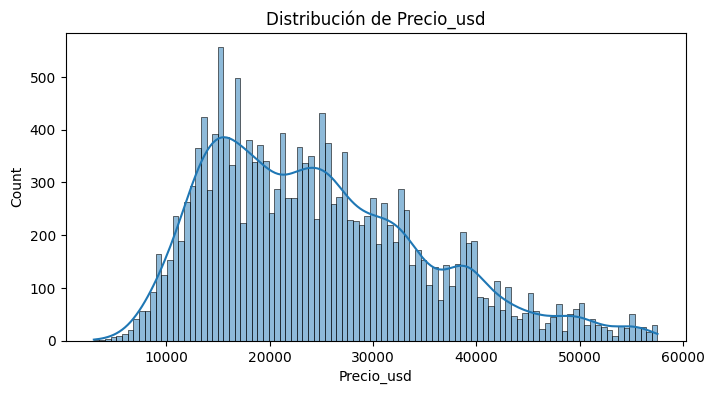

Kilómetros: datos fuera de rango eliminados. Filas restantes: 16881
antiguedad: datos fuera de rango eliminados. Filas restantes: 16881
Precio_usd: datos fuera de rango eliminados. Filas restantes: 16686
Puertas: datos fuera de rango eliminados. Filas restantes: 16686


C:\Users\andyd\AppData\Local\Temp\ipykernel_1916\4024359649.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


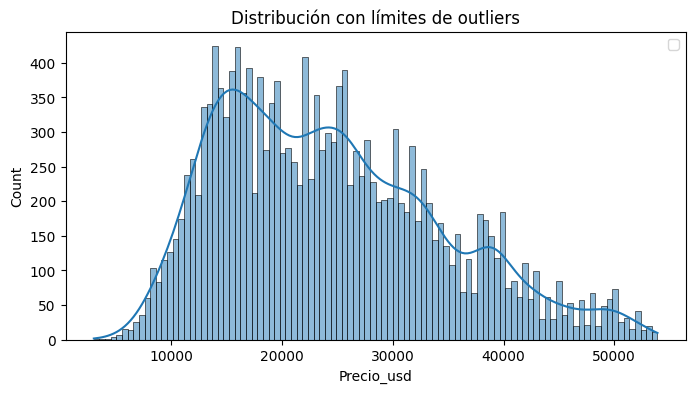

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
# Histograma del precio
plt.figure(figsize=(8, 4))
sns.histplot(df['Precio_usd'], bins=100, kde=True)
plt.title('Distribución de Precio_usd')
plt.show()


# Copia de trabajo
df_sin_outliers = df.copy()

# Lista de columnas numéricas
columnas_numericas = ['Kilómetros', 'antiguedad', 'Precio_usd', 'Puertas']  # ajustá según tu dataset

# Eliminar outliers en cada columna numérica
for col in columnas_numericas:
    Q1 = df_sin_outliers[col].quantile(0.25)
    Q3 = df_sin_outliers[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Filtramos dentro de los límites
    df_sin_outliers = df_sin_outliers[
        (df_sin_outliers[col] >= limite_inferior) & (df_sin_outliers[col] <= limite_superior)
    ]

    print(f"{col}: datos fuera de rango eliminados. Filas restantes: {df_sin_outliers.shape[0]}")


plt.figure(figsize=(8, 4))
sns.histplot(df_sin_outliers['Precio_usd'], bins=100, kde=True)
plt.title('Distribución con límites de outliers')
plt.legend()
plt.show()

In [10]:

# Definimos el filtro de outliers
filtro = (df['Precio_usd'] >= 3000)

# Dataset limpio (sin outliers)
df_sin_outliers = df_sin_outliers[filtro].reset_index(drop=True)

# Dataset con los outliers (lo que fue descartado)
df_outliers = df_sin_outliers[~filtro].reset_index(drop=True)


C:\Users\andyd\AppData\Local\Temp\ipykernel_1916\2244678273.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_sin_outliers = df_sin_outliers[filtro].reset_index(drop=True)
C:\Users\andyd\AppData\Local\Temp\ipykernel_1916\2244678273.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_outliers = df_sin_outliers[~filtro].reset_index(drop=True)


In [11]:
# guardar el dataset final
df.to_csv("dataset_final.csv", index=False)
print("Dataset final guardado como 'dataset_final.csv'.")

Dataset final guardado como 'dataset_final.csv'.


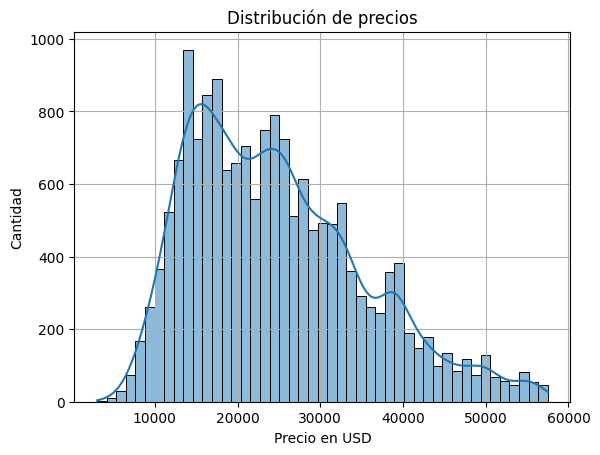

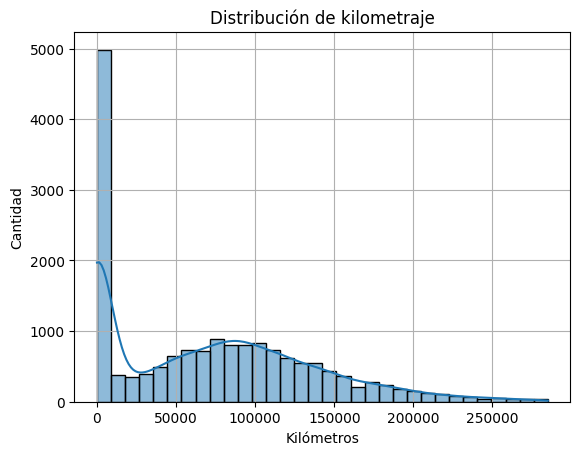

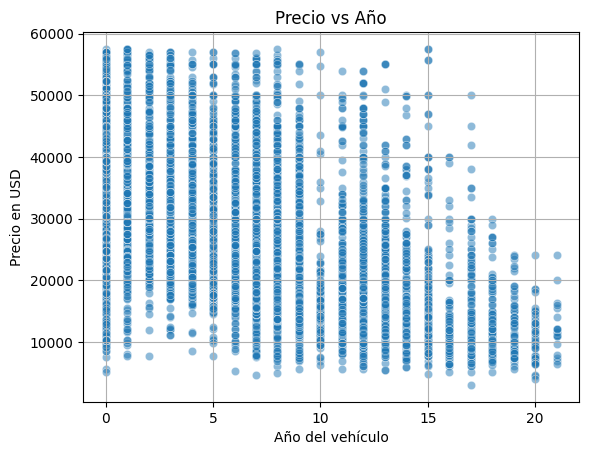

Columnas del dataset final:
['Puertas', 'Con cámara de retroceso', 'Kilómetros', 'Precio_usd', 'Marca_Alfa Romeo', 'Marca_Audi', 'Marca_BAIC', 'Marca_BMW', 'Marca_Chery', 'Marca_Chevrolet', 'Marca_Citroën', 'Marca_DS', 'Marca_Daihatsu', 'Marca_Dodge', 'Marca_Fiat', 'Marca_Ford', 'Marca_GWM', 'Marca_Haval', 'Marca_Honda', 'Marca_Hyundai', 'Marca_Isuzu', 'Marca_JAC', 'Marca_Jaguar', 'Marca_Jeep', 'Marca_Jetour', 'Marca_Jetur', 'Marca_KAIYI', 'Marca_Kia', 'Marca_LandRover', 'Marca_Lexus', 'Marca_Lifan', 'Marca_Mercedes-Benz', 'Marca_Mini', 'Marca_Mitsubishi', 'Marca_Nissan', 'Marca_Peugeot', 'Marca_Porsche', 'Marca_Renault', 'Marca_SsangYong', 'Marca_Subaru', 'Marca_Suzuki', 'Marca_Toyota', 'Marca_Volkswagen', 'Marca_Volvo', 'Traccion_2WD', 'Traccion_4M', 'Traccion_4x2', 'Traccion_4x4', 'Traccion_AWD', 'Traccion_Desconocida', 'Traccion_FWD', 'Color_Blanco', 'Color_Color', 'Color_Desconocido', 'Color_Gris', 'Color_Negro', 'Cilindrada', 'Combustible_Diésel', 'Combustible_Eléctrico', 'Combus

In [12]:
# Histograma de precios
sns.histplot(df['Precio_usd'], kde=True)
plt.title("Distribución de precios")
plt.xlabel("Precio en USD")
plt.ylabel("Cantidad")
plt.grid(True)
plt.show()

# Distribución de kilómetros
sns.histplot(df['Kilómetros'], kde=True)
plt.title("Distribución de kilometraje")
plt.xlabel("Kilómetros")
plt.ylabel("Cantidad")
plt.grid(True)
plt.show()

# Relación año vs. precio
sns.scatterplot(x='antiguedad', y='Precio_usd', data=df, alpha=0.5)
plt.title("Precio vs Año")
plt.xlabel("Año del vehículo")
plt.ylabel("Precio en USD")
plt.grid(True)
plt.show()


#printear columnas
print("Columnas del dataset final:")
print(df.columns.tolist())
